## Mitsiu Alejandro Carreño Sarabia - E235-18014

De las bases de datos mostradas, investiga cual se adapta mejor a los datos o resultados del segundo examen parcial.

Investiga como instalar esa base de datos o si hay bases en línea y carga tu información.

Entrega evidencia de los datos cargados.

Partiendo de los datos generados en el ejercicio de preprocesamiento, mi dataframe contiene 53 columnas, y 9433 renglones
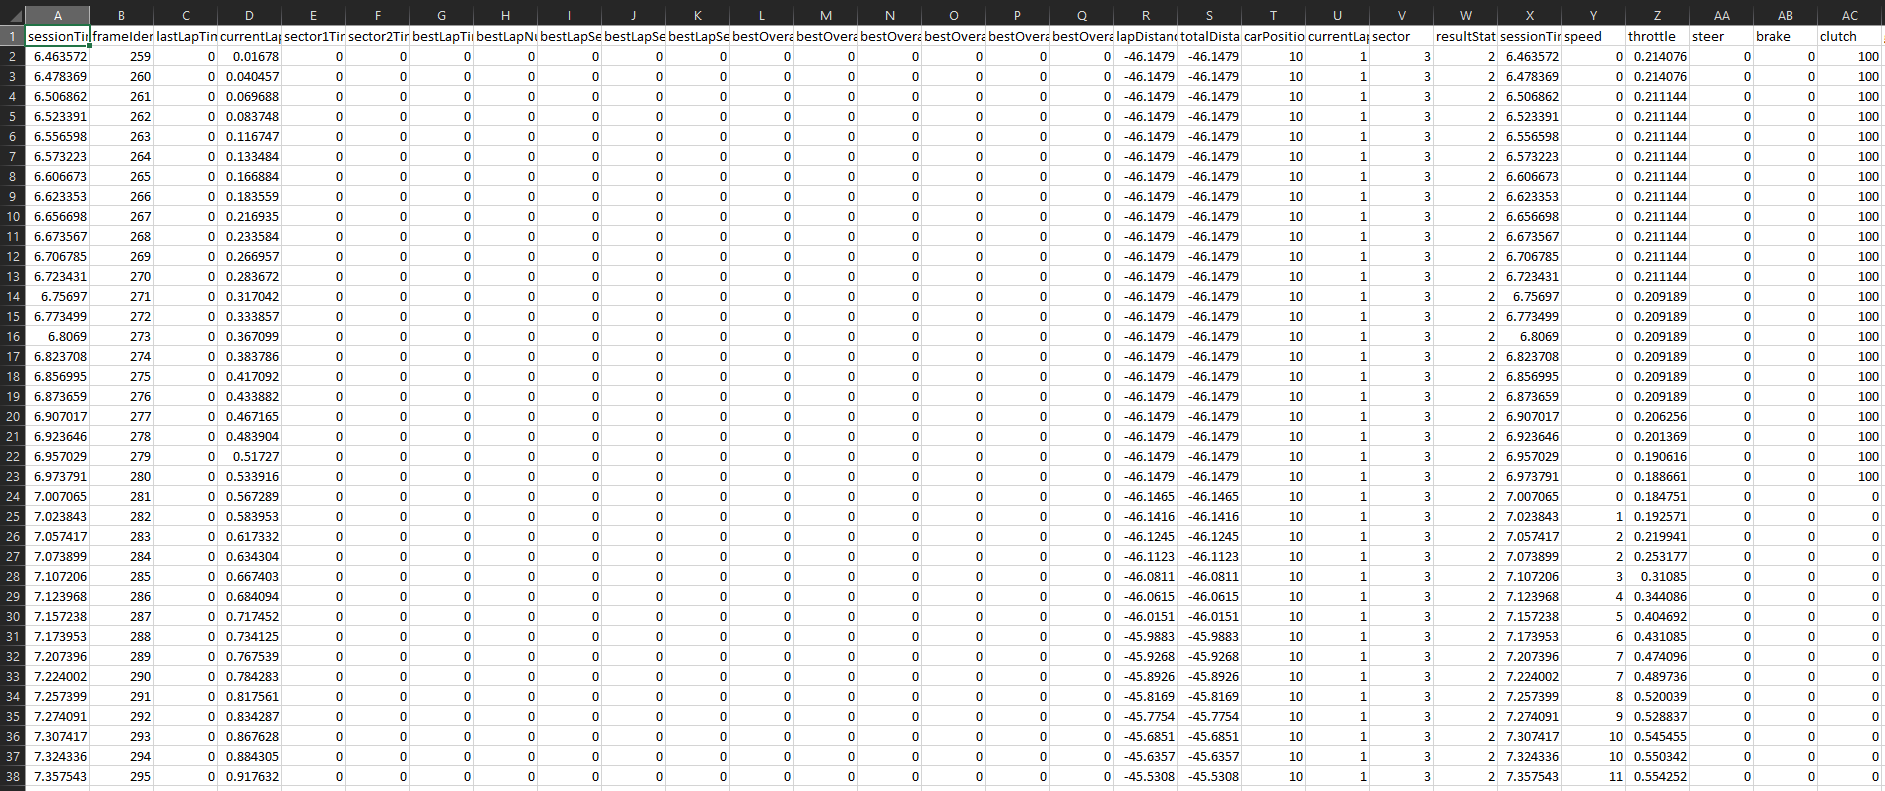

### Selección de modelo de base de datos
Dada el método de recopilación de los datos, se sabe que los campos son definidos y constantes, por lo que no es necesario una base de datos no estructurada, al final no se iba a aprovechar la flexibilidad que ofrece.

En este caso en específico una base de datos de grafos, tampoco era una opción factible, ya que no existen tantas entidades y relaciones para sacar provecho, tal vez sería una opción si se recopila la información de todos los coches (20) y más paquetes de información como reglajes de coche, estatus de coche, información de participantes, e información del evento, manejar la relación entre múltiples entidades, puede aprovechar mejor los grafos, pero por ahora no es el caso.

En general creo que los mejores modelos para almacenar la información del dataframe eran bases de datos relacionales, o columnares, y siendo franco, las relacionales ya las conozco por lo que las columnares me parecieron una opción atractiva para explorar las ventajas y desventajas del modelo.

### Apache Cassandra

La elección del gestor de base de datos fue en parte inspirado por el [tech-blog](https://discord.com/blog/how-discord-stores-trillions-of-messages) de Discord en el que explican su migración de [Cassandra](https://cassandra.apache.org/_/quickstart.html) a ScyllaDB, Cassandra siendo open-source gratuito y disponible en Docker, fue el sistema gestor elegido.

### Instalación
La instalación fue basada en este [blog](https://towardsdatascience.com/getting-started-with-apache-cassandra-and-python-81e00ccf17c9) creando un cluster con dos nodos y una estrategia de replicación “SimpleStrategy”.

El docker-compose empleado fue:
```yaml
version: '3'

services:
  cas1:
    container_name: cas1
    image: cassandra:latest
    volumes:
      - s12_db/data/node1:/var/lib/cassandra/data
    ports:
      - 9042:9042
    environment:
      - CASSANDRA_START_RPC=true
      - CASSANDRA_CLUSTER_NAME=MyCluster
      - CASSANDRA_ENDPOINT_SNITCH=GossipingPropertyFileSnitch
      - CASSANDRA_DC=datacenter1
    healthcheck:
      test: ["CMD", "curl", "-f", "http://localhost:9042"]
      interval: 30s
      timeout: 10s
      retries: 5
  cas2:
    container_name: cas2
    image: cassandra:latest
    volumes:
      - s12_db/data/node2:/var/lib/cassandra/data
    ports:
      - 9043:9042
    restart: on-failure
    depends_on:
      - cas1
    environment:
      - CASSANDRA_START_RPC=true
      - CASSANDRA_CLUSTER_NAME=MyCluster
      - CASSANDRA_ENDPOINT_SNITCH=GossipingPropertyFileSnitch
      - CASSANDRA_DC=datacenter1
      - CASSANDRA_SEEDS=cas1

```

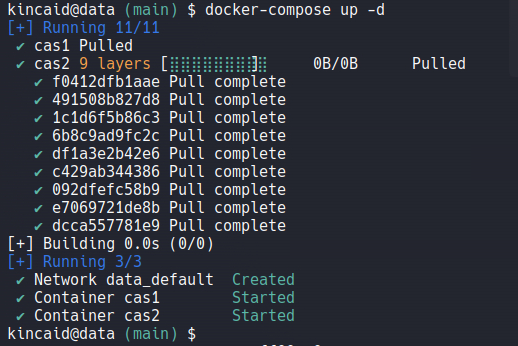

Y podemos realizar una evaluación de status de los contenedores
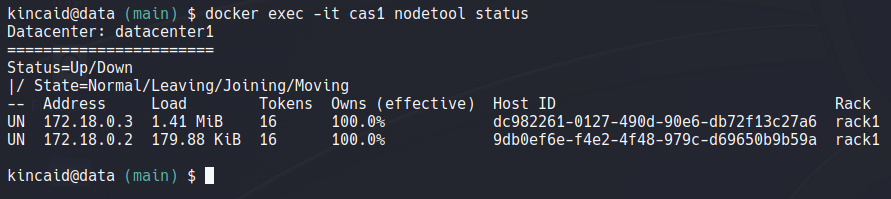

### Carga de datos
Para conectarnos usamos cqlsh en cualquiera de los contenedores de cassandra,recordemos que cualquier cambio realizado se replicará en el otro nodo (masterless).
Primero debemos crear el keyspace (base de datos)
```cql
CREATE KEYSPACE IF NOT EXISTS f1_telem
WITH REPLICATION ={
  'class': 'SimpleStrategy',
  'replication_factor': 2
};

USE f1_telem;
```

Una vez creado y seleccionado el keyspace, procedemos a crear la tabla para almacenar la información:
```cql
CREATE TABLE telem (
  sessionTime_x float,
  frameIdentifier int,
  lastLapTime float,
  currentLapTime float,
  sector1TimeInMS int,
  sector2TimeInMS int,
  bestLapTime float,
  bestLapNum tinyint,
  bestLapSector1TimeInMS int,
  bestLapSector2TimeInMS int,
  bestLapSector3TimeInMS int,
  bestOverallSector1TimeInMS int,
  bestOverallSector1LapNum tinyint,
  bestOverallSector2TimeInMS int,
  bestOverallSector2LapNum tinyint,
  bestOverallSector3TimeInMS int,
  bestOverallSector3LapNum tinyint,
  lapDistance float,
  totalDistance float,
  carPosition tinyint,
  currentLapNum tinyint,
  sector tinyint,
  resultStatus tinyint,
  sessionTime_y float,
  speed smallint,
  throttle float,
  steer float,
  brake float,
  clutch tinyint,
  gear tinyint,
  engineRPM smallint,
  revLightsPercent tinyint,
  brakesTempRearL smallint,
  brakesTempRearR smallint,
  brakesTempFrontL smallint,
  brakesTempFrontR smallint,
  tyresSurfaceTempRearL tinyint,
  tyresSurfaceTempRearR tinyint,
  tyresSurfaceTempFrontL tinyint,
  tyresSurfaceTempFrontR tinyint,
  tyresInnerTempRearL tinyint,
  tyresInnerTempRearR tinyint,
  tyresInnerTempFrontL tinyint,
  tyresInnerTempFrontR tinyint,
  engineTemperature smallint,
  tyresPressureRearL float,
  tyresPressureRearR float,
  tyresPressureFrontL float,
  tyresPressureFrontR float,
  surfaceTypeRearL text,
  surfaceTypeRearR text,
  surfaceTypeFrontL text,
  surfaceTypeFrontR text,

 PRIMARY KEY(sessionTime_x, frameIdentifier)
) WITH CLUSTERING ORDER BY (frameIdentifier DESC);
```


Cargamos el csv que vamos a importar al contenedor de cassandra:
```shell
docker cp F1_2020_tel.csv cas1:/home
```
Y usamos la implementación COPY de cqlsh para importar el contenido a la base de datos

```cql
COPY telem (
  sessionTime_x,
	frameIdentifier,
	lastLapTime,
	currentLapTime,
	sector1TimeInMS,
	sector2TimeInMS,
	bestLapTime,
	bestLapNum,
	bestLapSector1TimeInMS,
	bestLapSector2TimeInMS,
	bestLapSector3TimeInMS,
	bestOverallSector1TimeInMS,
	bestOverallSector1LapNum,
	bestOverallSector2TimeInMS,
	bestOverallSector2LapNum,
	bestOverallSector3TimeInMS,
	bestOverallSector3LapNum,
	lapDistance,
	totalDistance,
	carPosition,
	currentLapNum,
	sector,
	resultStatus,
	sessionTime_y,
	speed,
	throttle,
	steer,
	brake,
	clutch,
	gear,
	engineRPM,
	revLightsPercent,
	brakesTempRearL,
	brakesTempRearR,
	brakesTempFrontL,
	brakesTempFrontR,
	tyresSurfaceTempRearL,
	tyresSurfaceTempRearR,
	tyresSurfaceTempFrontL,
	tyresSurfaceTempFrontR,
	tyresInnerTempRearL,
	tyresInnerTempRearR,
	tyresInnerTempFrontL,
	tyresInnerTempFrontR,
	engineTemperature,
	tyresPressureRearL,
	tyresPressureRearR,
	tyresPressureFrontL,
	tyresPressureFrontR,
	surfaceTypeRearL,
	surfaceTypeRearR,
	surfaceTypeFrontL,
	surfaceTypeFrontR
    )
FROM 'home/F1_2020_tel.csv'
WITH HEADER = TRUE;

```

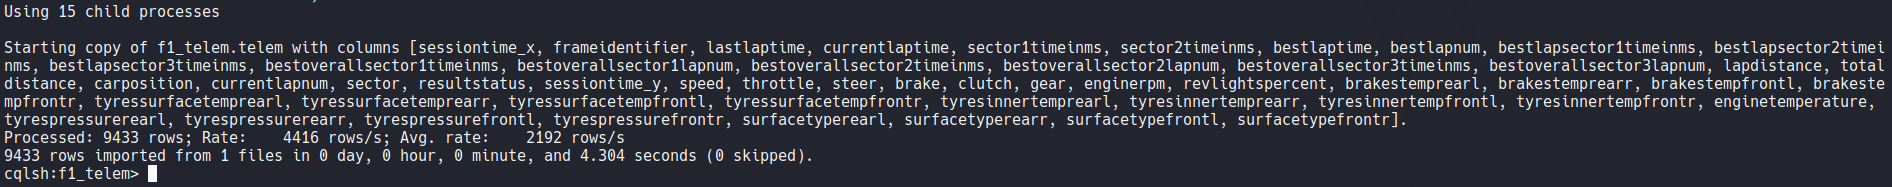

### Conexión Python
Una vez cargados los datos podemos consumirlos desde nuestro notebook de la siguiente manera.

In [ ]:
!pip install cassandra-driver

Defaulting to user installation because normal site-packages is not writeable


In [1]:
from cassandra.cluster import Cluster

cluster = Cluster(['0.0.0.0'],port=9042)
session = cluster.connect('f1_telem',wait_for_all_pools=True)
session.execute('USE f1_telem')
rows = session.execute('SELECT sessiontime_x, speed, throttle FROM telem')
for row in rows:
    print(f"{row.sessiontime_x}\t{row.speed}\t{row.throttle}")